In [14]:
# =============================
# Setup: Kaggle + Paths
# =============================
!pip install -q kaggle

import os

# Make a kaggle folder and place your Kaggle API key JSON here (upload manually in Colab sidebar or use files.upload())
os.makedirs("/root/.kaggle", exist_ok=True)

# Example: If you uploaded kaggle.json in Colab's file explorer
!cp kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json

# Download and unzip dataset
!kaggle datasets download -d bhavikjikadara/dog-and-cat-classification-dataset -p /content/
!unzip -q /content/dog-and-cat-classification-dataset.zip -d /content/dataset


Dataset URL: https://www.kaggle.com/datasets/bhavikjikadara/dog-and-cat-classification-dataset
License(s): apache-2.0
dog-and-cat-classification-dataset.zip: Skipping, found more recently modified local copy (use --force to force download)
replace /content/dataset/PetImages/Cat/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [15]:

# =============================
# Imports
# =============================
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import seaborn as sns
from datetime import datetime
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, callbacks

In [16]:
# =============================
# Paths for saving outputs
# =============================
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')

base_path = '/content/models'
os.makedirs(base_path, exist_ok=True)

model_save_path = f'{base_path}/cat_dog_cnn_model.h5'
acc_plot_path = f'{base_path}/accuracy_plot_{timestamp}.png'
conf_matrix_plot_path = f'{base_path}/confusion_matrix_{timestamp}.png'
log_file_path = f'{base_path}/training_log_{timestamp}.csv'


In [17]:

# =============================
# Dataset Path
# =============================
original_data_dir = '/content/dataset/PetImages'

# Data generators with augmentation for training and rescaling for validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.1,
    # zoom_range=0.2,
    horizontal_flip=True,
    # brightness_range=[0.8, 1.2],
    # fill_mode='nearest',
    validation_split=0.2
)

val_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_generator = train_datagen.flow_from_directory(
    original_data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True  #The order of the training samples is randomized at the start of each epoch.
)

val_generator = val_datagen.flow_from_directory(
    original_data_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    subset='validation',
    shuffle=False
)


Found 20000 images belonging to 2 classes.
Found 4998 images belonging to 2 classes.




```python
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    # width_shift_range=0.2,
    # height_shift_range=0.2,
    # shear_range=0.1,
    # zoom_range=0.2,
    horizontal_flip=True,
    # brightness_range=[0.8, 1.2],
    # fill_mode='nearest',
    validation_split=0.2
)
```

---

###  `rescale=1./255`

* Scales pixel values from **0–255 → 0–1**.
* Normalization makes training faster and more stable.

---

###  `rotation_range=20`

* Randomly rotates images within **±20 degrees**.
* Helps the model become invariant to rotated dogs/cats.

---

###  `horizontal_flip=True`

* Randomly flips images horizontally.
* Useful because cats/dogs facing left or right should still be recognized the same.

---

###  `validation_split=0.2`

* Reserves **20% of data for validation**.
* Later, you tell `flow_from_directory(..., subset="training")` or `"validation"` which part to use.

---

###  The commented-out options (if enabled):

* **`width_shift_range=0.2`** → shifts images left/right up to 20% of width.
* **`height_shift_range=0.2`** → shifts images up/down.
* **`shear_range=0.1`** → applies shearing (slanting effect).
* **`zoom_range=0.2`** → randomly zooms in/out by up to 20%.
* **`brightness_range=[0.8, 1.2]`** → varies brightness randomly (darker/brighter images).
* **`fill_mode='nearest'`** → how to fill in empty pixels after transformations (nearest pixel value).

---

 **Big picture:**

* These augmentations **increase dataset diversity artificially**, so the model generalizes better.
* They are applied **only to the training set**, not validation/test.

---





---

###  Training generator → `shuffle=True`

* In training, the model should not see data in the exact same order every epoch.
* Shuffling:

  * Reduces the chance of the model simply memorizing the order.
  * Makes batches more diverse → helps generalization.
* That’s why **we always shuffle training data**.

---

###  Validation/Test generator → `shuffle=False`

* Validation is about **measuring performance** after each epoch.
* We want results to be **deterministic and reproducible**:

  * Same samples in the same order each epoch.
  * This makes metrics (accuracy, loss, confusion matrix, ROC, etc.) consistent.
* If validation was shuffled:

  * Predictions might align with different samples each time → messing up metrics.
  * Confusion matrices would mismatch (predicted vs true labels).

---

 **Summary:**

* `shuffle=True` for training → improves learning.
* `shuffle=False` for validation/test → ensures stable, repeatable evaluation.

---


In [18]:


print("Class Indices:", train_generator.class_indices)


Class Indices: {'Cat': 0, 'Dog': 1}


Batch shape: (32, 150, 150, 3)
Labels shape: (32,)


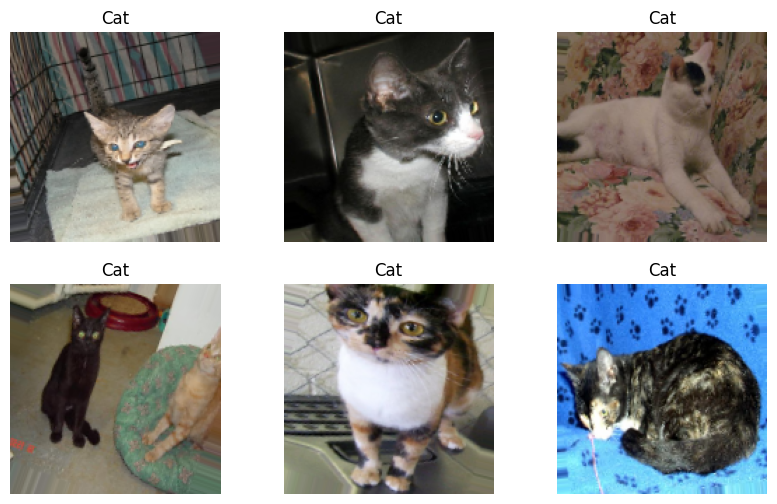

In [19]:

# Get one batch of images and labels
images, labels = next(train_generator)   # or next(val_generator)

print("Batch shape:", images.shape)
print("Labels shape:", labels.shape)

# Plot a few images
plt.figure(figsize=(10, 6))
for i in range(6):   # show first 6 images
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i])   # images are already rescaled (0–1)
    label = "Dog" if labels[i] == 1 else "Cat"
    plt.title(label)
    plt.axis("off")
plt.show()

Explanation:

next(generator) gives you one batch of (X, y)

X = images → shape (batch_size, 150, 150, 3)

y = labels → shape (batch_size,) (binary: 0 = Cat, 1 = Dog)

We then plot a few images using matplotlib.

In [20]:

# CNN Model

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling2D(2, 2),
    layers.Dropout(0.25),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:

# =============================
# Train Model
# =============================
csv_logger = callbacks.CSVLogger(log_file_path, append=False)

history = model.fit(
    train_generator,
    epochs=6,
    validation_data=val_generator,
    callbacks=[csv_logger],
    verbose=1
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/6
349/625 ━━━━━━━━━━━━━━━━━━━━ 56s 203ms/step - accuracy: 0.5646 - loss: 3.9461

/usr/local/lib/python3.12/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 ━━━━━━━━━━━━━━━━━━━━ 151s 216ms/step - accuracy: 0.5867 - loss: 2.7723 - val_accuracy: 0.6279 - val_loss: 0.8783
Epoch 2/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 133s 213ms/step - accuracy: 0.6727 - loss: 0.6042 - val_accuracy: 0.6945 - val_loss: 0.5671
Epoch 3/6
404/625 ━━━━━━━━━━━━━━━━━━━━ 44s 201ms/step - accuracy: 0.6884 - loss: 0.5789

In [ ]:


# Save the model
model.save(model_save_path)

In [ ]:

# =============================
# Accuracy Plot
# =============================
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy vs Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()
# plt.savefig(acc_plot_path)
# plt.close()

In [ ]:

# =============================
# Confusion Matrix
# =============================
val_generator.reset() # to ensure the generator starts from the first record
pred_probs = model.predict(val_generator, verbose=1)
pred_classes = (pred_probs > 0.5).astype("int32").flatten()
true_classes = val_generator.classes

conf_mat = confusion_matrix(true_classes, pred_classes)
plt.figure(figsize=(6, 5))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(train_generator.class_indices.keys()),
            yticklabels=list(train_generator.class_indices.keys()))
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# plt.savefig(conf_matrix_plot_path)
# plt.close()

print(f"Model saved to: {model_save_path}")
print(f"Accuracy plot saved to: {acc_plot_path}")
print(f"Confusion matrix plot saved to: {conf_matrix_plot_path}")
print(f"Training log saved to: {log_file_path}")


In [ ]:
from sklearn.metrics import classification_report
import numpy as np
# Generate classification report
class_labels = list(val_generator.class_indices.keys())  # ['Cat', 'Dog']
report = classification_report(true_classes, pred_classes, target_names=class_labels)
print(report)